<a href="https://colab.research.google.com/github/isaacmenchaca97/EfficientNetB0/blob/main/general_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Procesamiento Digital de Imágenes para Clasificación General de Imágenes: Proyecto Final
###Isaac Menchaca Panecatl
###Dr. Ulises Moya
###Maestría en Ciencias de la Computación
**Basado en el artículo**: [EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks](https://arxiv.org/abs/1905.11946)  (2019), de Mingxing Tan y Quoc V. Le, que introduce un enfoque innovador para escalar redes neuronales convolucionales (CNNs) de manera eficiente y efectiva.

**Objetivo**: Desarrollar un sistema de clasificación de imágenes utilizando el modelo preentrenado EfficientNet-B0, evaluando el impacto de diversas técnicas de procesamiento digital de imágenes (desenfoque y ruido) en el rendimiento del modelo al clasificar 100 imágenes generales de un conjunto de datos seleccionado.

**Metodología**:


1.   Preparación de datos: Seleccionar 100 imágenes de un conjunto de datos de propósito general.
Realizar preprocesamiento para estandarizar el tamaño de entrada al modelo EfficientNet-B0.
2.   Clasificación base: Usar el modelo EfficientNet-B0 preentrenado para clasificar las imágenes originales y registrar las métricas.
1.   Pruebas con procesamiento de imágenes:
  - Desenfoque: Aplicar un filtro de desenfoque (Desenfoque Gaussiano) a las imágenes y realizar la clasificación usando EfficientNet-B0.
  - Ruido: Añadir ruido aleatorio (sal y pimienta) a las imágenes y repetir la clasificación.
2.   Análisis de resultados: Comparar las métricas de clasificación entre las imágenes originales y procesadas. Evaluar cómo cada técnica de procesamiento de imágenes influye en el rendimiento del modelo.
1.   Conclusiones: Identificar qué modificaciones de las imágenes afectan de manera positiva o negativa la precisión de la clasificación.


**Enlace al video**:

##1. Data Preparation

In [23]:
#!/usr/bin/env python
## -*- coding: utf-8 -*-
__author__ = ["Isaac Menchaca Panecatl"]
__copyright__ = "Copyright 2024"
__credits__ = ["Isaac Menchaca Panecatl"]
__license__ = "MIT"
__version__ = "0.0.1"
__maintainer__ = ["Isaac Menchaca Panecatl"]
__email__ = "isaac.menchaca@edu.uag.mx"
__status__ = "Development"

import torch
from pycocotools.coco import COCO
from PIL import Image, ImageFilter
import torchvision.transforms as transforms
import numpy as np
import json
import requests
import matplotlib.pyplot as plt
import warnings
import os
from urllib.parse import urlparse
from torchvision.models import efficientnet_b0
import urllib.request
from sklearn.metrics import accuracy_score, precision_score, recall_score, classification_report
warnings.filterwarnings('ignore')
%matplotlib inline

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

Using cpu for inference


In [24]:
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip -O coco_ann2017.zip
!unzip coco_ann2017.zip

--2024-12-06 23:53:32--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 3.5.28.125, 52.216.58.137, 3.5.25.88, ...
Connecting to images.cocodataset.org (images.cocodataset.org)|3.5.28.125|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘coco_ann2017.zip’

coco_ann2017.zip    100%[===================>] 241.19M  55.2MB/s    in 4.7s    

2024-12-06 23:53:37 (51.0 MB/s) - ‘coco_ann2017.zip’ saved [252907541/252907541]

Archive:  coco_ann2017.zip
replace annotations/instances_train2017.json? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [25]:
# Ruta al archivo de anotaciones (puedes descargarlo desde el sitio de COCO)
annFile = 'annotations/instances_val2017.json'

# Cargar el archivo de anotaciones
coco = COCO(annFile)

# Obtener los IDs de las imágenes
img_ids = coco.getImgIds()

# Generar una lista con las URLs de las imágenes
base_url = 'http://images.cocodataset.org/val2017/'  # Cambia según el conjunto de datos

uris = []
uris_name = []

# Obtener las URLs para las primeras 100 imágenes
for img_id in img_ids[:100]:
    img_info = coco.loadImgs(img_id)[0]
    img_url = base_url + img_info['file_name']
    uris.append(img_url)
    uris_name.append(img_info['file_name'])

# Ver las primeras 10 URLs generadas
for uri in uris[:10]:
    print(uri)

loading annotations into memory...
Done (t=1.50s)
creating index...
index created!
http://images.cocodataset.org/val2017/000000397133.jpg
http://images.cocodataset.org/val2017/000000037777.jpg
http://images.cocodataset.org/val2017/000000252219.jpg
http://images.cocodataset.org/val2017/000000087038.jpg
http://images.cocodataset.org/val2017/000000174482.jpg
http://images.cocodataset.org/val2017/000000403385.jpg
http://images.cocodataset.org/val2017/000000006818.jpg
http://images.cocodataset.org/val2017/000000480985.jpg
http://images.cocodataset.org/val2017/000000458054.jpg
http://images.cocodataset.org/val2017/000000331352.jpg


In [26]:
# Función para descargar y guardar la imagen
def download_image(url, save_folder):
    # Hacer la solicitud HTTP para obtener la imagen
    response = requests.get(url)

    # Verificar que la solicitud fue exitosa
    if response.status_code == 200:
        # Obtener el nombre de la imagen a partir de la URL
        image_name = os.path.basename(urlparse(url).path)

        # Crear la ruta completa para guardar la imagen
        save_path = os.path.join(save_folder, image_name)

        # Guardar la imagen en el directorio especificado
        with open(save_path, 'wb') as f:
            f.write(response.content)
        print(f"Imagen guardada en: {save_path}")
    else:
        print(f"Error al descargar la imagen: {url}")

# Carpeta donde se guardarán las imágenes
save_folder = 'downloaded_images'

# Crear la carpeta si no existe
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

# Descargar y guardar cada imagen
for url in uris:
    download_image(url, save_folder)

Imagen guardada en: downloaded_images/000000397133.jpg
Imagen guardada en: downloaded_images/000000037777.jpg
Imagen guardada en: downloaded_images/000000252219.jpg
Imagen guardada en: downloaded_images/000000087038.jpg
Imagen guardada en: downloaded_images/000000174482.jpg
Imagen guardada en: downloaded_images/000000403385.jpg
Imagen guardada en: downloaded_images/000000006818.jpg
Imagen guardada en: downloaded_images/000000480985.jpg
Imagen guardada en: downloaded_images/000000458054.jpg
Imagen guardada en: downloaded_images/000000331352.jpg
Imagen guardada en: downloaded_images/000000296649.jpg
Imagen guardada en: downloaded_images/000000386912.jpg
Imagen guardada en: downloaded_images/000000502136.jpg
Imagen guardada en: downloaded_images/000000491497.jpg
Imagen guardada en: downloaded_images/000000184791.jpg
Imagen guardada en: downloaded_images/000000348881.jpg
Imagen guardada en: downloaded_images/000000289393.jpg
Imagen guardada en: downloaded_images/000000522713.jpg
Imagen gua

##2. Baseline Classification

In [27]:
# Cargar el modelo preentrenado
model = efficientnet_b0(pretrained=True)

# Cambiar a modo de evaluación (inferencia)
model.eval()

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [28]:
# Transformaciones necesarias
preprocess = transforms.Compose([
    transforms.Resize(256),                # Escalar el lado más pequeño a 256 píxeles
    transforms.CenterCrop(224),            # Recortar el centro a 224x224
    transforms.ToTensor(),                 # Convertir a tensor
    transforms.Normalize(                  # Normalizar con medias y desviaciones estándar de ImageNet
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

In [29]:
url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
response = urllib.request.urlopen(url)
labels = json.load(response)

predictions = []
y_true = []
y_pred = []

print(f"{'Predicción':<25}{'Etiqueta':<10}{'Confianza (%)':<15}{'Imagen'}")
print("=" * 60)

for name in uris_name:
    # Cargar una imagen
    image = Image.open("downloaded_images/" + name).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0)  # Añadir dimensión batch

    # Desactivar gradientes para inferencia más rápida
    with torch.no_grad():
        output = model(input_tensor)

    # Convertir salidas a probabilidades con softmax
    probabilities = torch.nn.functional.softmax(output[0], dim=0)

    # Mostrar la clase más probable
    top1_idx = probabilities.argmax().item()
    print(f"{labels[top1_idx]:<25}{top1_idx:<10}{probabilities[top1_idx]*100:<15.2f}{base_url + name}")

    y_pred.append(top1_idx)
    if probabilities[top1_idx] > 0.5:
        y_true.append(top1_idx)
    else:
        y_true.append(0)

    predictions.append(float(probabilities[top1_idx]*100))

Predicción               Etiqueta  Confianza (%)  Imagen
restaurant               762       57.56          http://images.cocodataset.org/val2017/000000397133.jpg
microwave oven           651       87.48          http://images.cocodataset.org/val2017/000000037777.jpg
shopping cart            791       11.62          http://images.cocodataset.org/val2017/000000252219.jpg
unicycle                 880       99.36          http://images.cocodataset.org/val2017/000000087038.jpg
moped                    665       37.55          http://images.cocodataset.org/val2017/000000174482.jpg
toilet seat              861       31.58          http://images.cocodataset.org/val2017/000000403385.jpg
toilet seat              861       33.82          http://images.cocodataset.org/val2017/000000006818.jpg
scooter                  670       30.81          http://images.cocodataset.org/val2017/000000480985.jpg
tub                      876       24.50          http://images.cocodataset.org/val2017/000000458054.jp

In [41]:
# Calcular las métricas
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='micro')
recall = recall_score(y_true, y_pred, average='micro')

# Mostrar las métricas
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy: 0.45
Precision: 0.45
Recall: 0.45


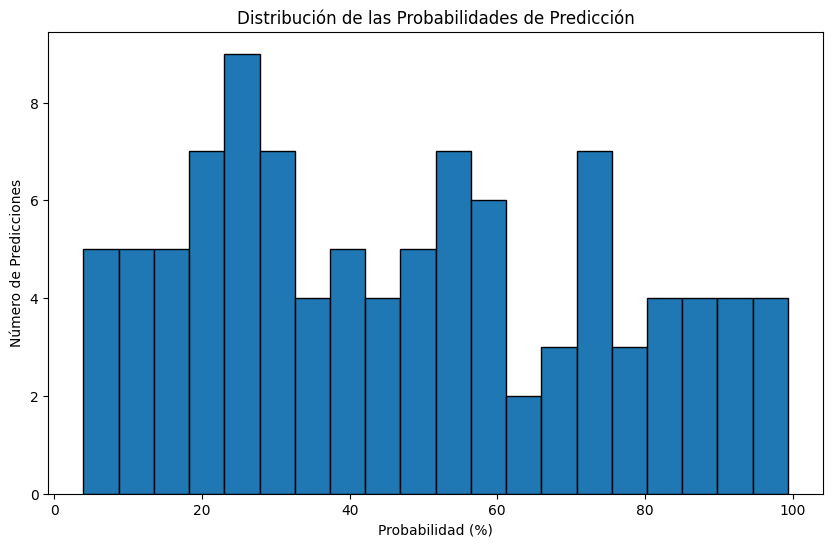

In [31]:
# Graficar el histograma de las probabilidades
plt.figure(figsize=(10, 6))
plt.hist(predictions, bins=20, edgecolor='black')
plt.title("Distribución de las Probabilidades de Predicción")
plt.xlabel("Probabilidad (%)")
plt.ylabel("Número de Predicciones")
plt.show()


##3. Testing with Image Processing

###Blur

In [32]:
# Función para aplicar blur a una imagen y guardarla
def apply_blur_and_save(image_path, output_folder):
    try:
        # Abrir la imagen
        img = Image.open(image_path)

        # Aplicar efecto blur
        img_blurred = img.filter(ImageFilter.GaussianBlur(radius=5))  # Cambiar el radio para ajustar el desenfoque

        # Crear la ruta para guardar la imagen con blur
        image_name = os.path.basename(image_path)
        save_path = os.path.join(output_folder, image_name)

        # Guardar la imagen con el efecto blur
        img_blurred.save(save_path)
        print(f"Imagen con blur guardada en: {save_path}")
    except Exception as e:
        print(f"Error al procesar la imagen {image_path}: {e}")

# Carpeta de imágenes descargadas
input_folder = 'downloaded_images'

# Carpeta para guardar imágenes con blur
output_folder = 'blurred_images'

# Crear la carpeta de salida si no existe
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Aplicar efecto blur a cada imagen de la carpeta descargada
for image_file in os.listdir(input_folder):
    image_path = os.path.join(input_folder, image_file)
    apply_blur_and_save(image_path, output_folder)


Imagen con blur guardada en: blurred_images/000000515579.jpg
Imagen con blur guardada en: blurred_images/000000430961.jpg
Imagen con blur guardada en: blurred_images/000000239347.jpg
Imagen con blur guardada en: blurred_images/000000515445.jpg
Imagen con blur guardada en: blurred_images/000000199551.jpg
Imagen con blur guardada en: blurred_images/000000486438.jpg
Imagen con blur guardada en: blurred_images/000000173383.jpg
Imagen con blur guardada en: blurred_images/000000577539.jpg
Imagen con blur guardada en: blurred_images/000000443303.jpg
Imagen con blur guardada en: blurred_images/000000125211.jpg
Imagen con blur guardada en: blurred_images/000000360661.jpg
Imagen con blur guardada en: blurred_images/000000356427.jpg
Imagen con blur guardada en: blurred_images/000000312421.jpg
Imagen con blur guardada en: blurred_images/000000058636.jpg
Imagen con blur guardada en: blurred_images/000000347693.jpg
Imagen con blur guardada en: blurred_images/000000555705.jpg
Imagen con blur guardada

In [33]:
predictions_blur = []
y_pred_blur = []

for name in uris_name:
    # Cargar una imagen
    image = Image.open("blurred_images/" + name).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0)  # Añadir dimensión batch

    # Desactivar gradientes para inferencia más rápida
    with torch.no_grad():
        output = model(input_tensor)

    # Convertir salidas a probabilidades con softmax
    probabilities = torch.nn.functional.softmax(output[0], dim=0)

    # Mostrar la clase más probable
    top1_idx = probabilities.argmax().item()
    print(f"Predicción: {labels[top1_idx]} (Confianza: {probabilities[top1_idx]*100:.2f}%)")

    y_pred_blur.append(top1_idx)

    predictions_blur.append(float(probabilities[top1_idx]*100))

Predicción: balance beam (Confianza: 13.40%)
Predicción: pill bottle (Confianza: 63.57%)
Predicción: moving van (Confianza: 14.19%)
Predicción: pulled rickshaw (Confianza: 9.95%)
Predicción: moped (Confianza: 26.87%)
Predicción: switch (Confianza: 15.95%)
Predicción: beaker (Confianza: 8.71%)
Predicción: toy store (Confianza: 8.04%)
Predicción: ring binder (Confianza: 23.12%)
Predicción: toilet seat (Confianza: 51.34%)
Predicción: pulled rickshaw (Confianza: 4.09%)
Predicción: library (Confianza: 21.68%)
Predicción: sawmill (Confianza: 2.00%)
Predicción: four-poster bed (Confianza: 18.23%)
Predicción: tray (Confianza: 12.67%)
Predicción: beaker (Confianza: 13.02%)
Predicción: Sussex Spaniel (Confianza: 6.80%)
Predicción: golf ball (Confianza: 17.43%)
Predicción: dromedary (Confianza: 4.43%)
Predicción: semi-trailer truck (Confianza: 8.18%)
Predicción: moving van (Confianza: 71.98%)
Predicción: school bus (Confianza: 11.98%)
Predicción: mobile home (Confianza: 29.41%)
Predicción: monast

In [42]:
# Calcular las métricas
accuracy = accuracy_score(y_true, y_pred_blur)
precision = precision_score(y_true, y_pred_blur, average='micro')
recall = recall_score(y_true, y_pred_blur, average='micro')

# Mostrar las métricas
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy: 0.17
Precision: 0.17
Recall: 0.17


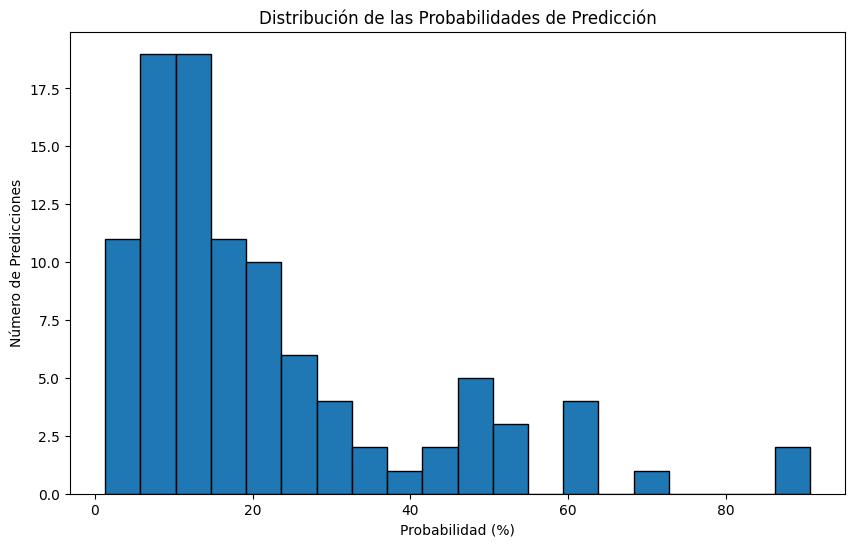

In [35]:
# Graficar el histograma de las probabilidades
plt.figure(figsize=(10, 6))
plt.hist(predictions_blur, bins=20, edgecolor='black')
plt.title("Distribución de las Probabilidades de Predicción")
plt.xlabel("Probabilidad (%)")
plt.ylabel("Número de Predicciones")
plt.show()

###Noise

In [36]:
# Función para aplicar ruido sal y pimienta a una imagen y guardarla
def apply_salt_and_pepper_noise(image_path, output_folder, amount=0.02, salt_vs_pepper=0.5):
    try:
        # Abrir la imagen
        img = Image.open(image_path).convert('RGB')  # Convertir a RGB si no lo está
        img_array = np.array(img)

        # Crear máscara para ruido
        num_pixels = img_array.size
        num_salt = int(amount * num_pixels * salt_vs_pepper)
        num_pepper = int(amount * num_pixels * (1.0 - salt_vs_pepper))

        # Agregar ruido tipo "sal" (blanco)
        coords = [np.random.randint(0, i - 1, num_salt) for i in img_array.shape]
        img_array[coords[0], coords[1], :] = 255

        # Agregar ruido tipo "pimienta" (negro)
        coords = [np.random.randint(0, i - 1, num_pepper) for i in img_array.shape]
        img_array[coords[0], coords[1], :] = 0

        # Convertir el array a imagen
        noisy_img = Image.fromarray(img_array)

        # Crear la ruta para guardar la imagen con ruido
        image_name = os.path.basename(image_path)
        save_path = os.path.join(output_folder, image_name)

        # Guardar la imagen con el ruido aplicado
        noisy_img.save(save_path)
        print(f"Imagen con ruido guardada en: {save_path}")
    except Exception as e:
        print(f"Error al procesar la imagen {image_path}: {e}")

# Carpeta de imágenes descargadas
input_folder = 'downloaded_images'

# Carpeta para guardar imágenes con ruido
output_folder = 'noisy_images'

# Crear la carpeta de salida si no existe
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

# Aplicar ruido sal y pimienta a cada imagen de la carpeta descargada
for image_file in os.listdir(input_folder):
    image_path = os.path.join(input_folder, image_file)
    apply_salt_and_pepper_noise(image_path, output_folder)

Imagen con ruido guardada en: noisy_images/000000515579.jpg
Imagen con ruido guardada en: noisy_images/000000430961.jpg
Imagen con ruido guardada en: noisy_images/000000239347.jpg
Imagen con ruido guardada en: noisy_images/000000515445.jpg
Imagen con ruido guardada en: noisy_images/000000199551.jpg
Imagen con ruido guardada en: noisy_images/000000486438.jpg
Imagen con ruido guardada en: noisy_images/000000173383.jpg
Imagen con ruido guardada en: noisy_images/000000577539.jpg
Imagen con ruido guardada en: noisy_images/000000443303.jpg
Imagen con ruido guardada en: noisy_images/000000125211.jpg
Imagen con ruido guardada en: noisy_images/000000360661.jpg
Imagen con ruido guardada en: noisy_images/000000356427.jpg
Imagen con ruido guardada en: noisy_images/000000312421.jpg
Imagen con ruido guardada en: noisy_images/000000058636.jpg
Imagen con ruido guardada en: noisy_images/000000347693.jpg
Imagen con ruido guardada en: noisy_images/000000555705.jpg
Imagen con ruido guardada en: noisy_imag

In [37]:
predictions_noise = []
y_pred_noise = []

for name in uris_name:
    # Cargar una imagen
    image = Image.open("noisy_images/" + name).convert("RGB")
    input_tensor = preprocess(image).unsqueeze(0)  # Añadir dimensión batch

    # Desactivar gradientes para inferencia más rápida
    with torch.no_grad():
        output = model(input_tensor)

    # Convertir salidas a probabilidades con softmax
    probabilities = torch.nn.functional.softmax(output[0], dim=0)

    # Mostrar la clase más probable
    top1_idx = probabilities.argmax().item()
    print(f"Predicción: {labels[top1_idx]} (Confianza: {probabilities[top1_idx]*100:.2f}%)")

    y_pred_noise.append(top1_idx)

    predictions_noise.append(float(probabilities[top1_idx]*100))

Predicción: restaurant (Confianza: 12.93%)
Predicción: snowplow (Confianza: 6.73%)
Predicción: West Highland White Terrier (Confianza: 11.86%)
Predicción: unicycle (Confianza: 47.44%)
Predicción: mountain bike (Confianza: 48.16%)
Predicción: toilet seat (Confianza: 37.71%)
Predicción: sink (Confianza: 24.58%)
Predicción: snowmobile (Confianza: 13.03%)
Predicción: pot (Confianza: 6.72%)
Predicción: sink (Confianza: 9.58%)
Predicción: prison (Confianza: 8.66%)
Predicción: jigsaw puzzle (Confianza: 39.95%)
Predicción: prison (Confianza: 49.26%)
Predicción: bookcase (Confianza: 34.72%)
Predicción: tray (Confianza: 35.27%)
Predicción: baluster (Confianza: 17.42%)
Predicción: llama (Confianza: 56.53%)
Predicción: park bench (Confianza: 59.65%)
Predicción: water buffalo (Confianza: 28.17%)
Predicción: garbage truck (Confianza: 16.30%)
Predicción: moving van (Confianza: 18.11%)
Predicción: taxicab (Confianza: 24.87%)
Predicción: minibus (Confianza: 43.65%)
Predicción: trolleybus (Confianza: 45

In [43]:
# Calcular las métricas
accuracy = accuracy_score(y_true, y_pred_noise)
precision = precision_score(y_true, y_pred_noise, average='micro')
recall = recall_score(y_true, y_pred_noise, average='micro')

# Mostrar las métricas
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")

Accuracy: 0.28
Precision: 0.28
Recall: 0.28


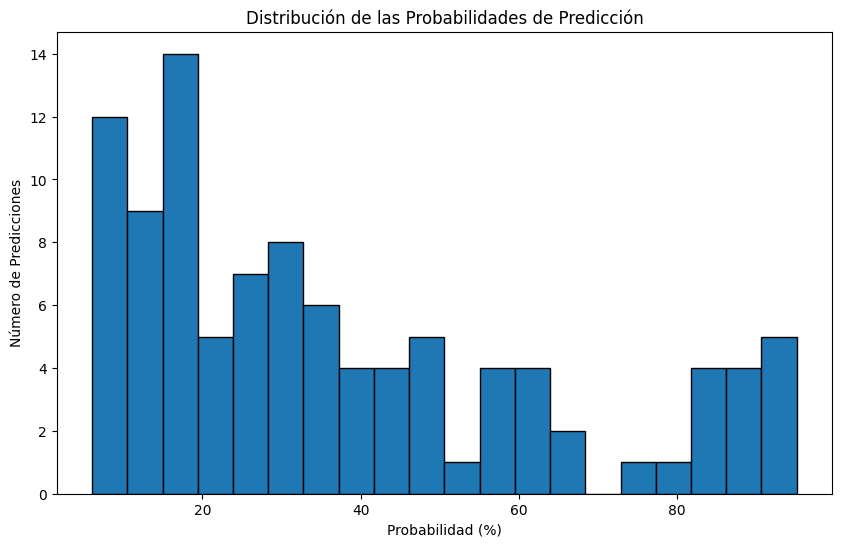

In [39]:
# Graficar el histograma de las probabilidades
plt.figure(figsize=(10, 6))
plt.hist(predictions_noise, bins=20, edgecolor='black')
plt.title("Distribución de las Probabilidades de Predicción")
plt.xlabel("Probabilidad (%)")
plt.ylabel("Número de Predicciones")
plt.show()

##4. Results Analysis

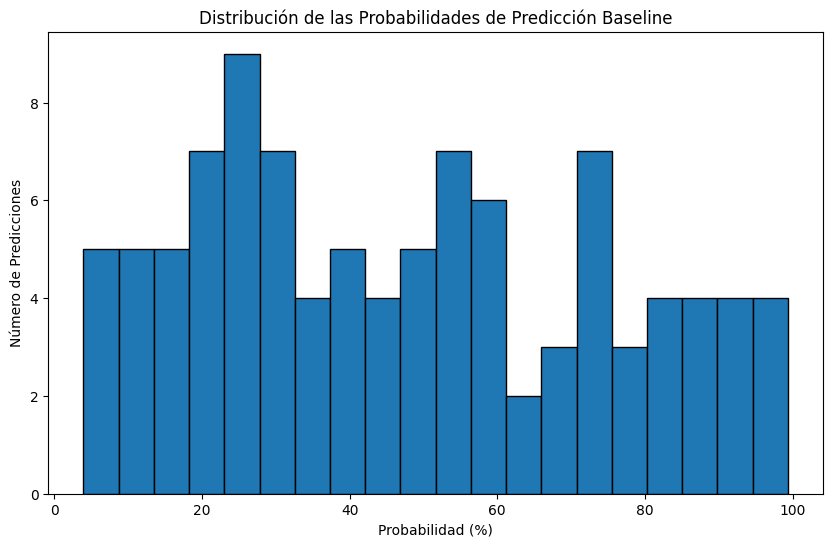

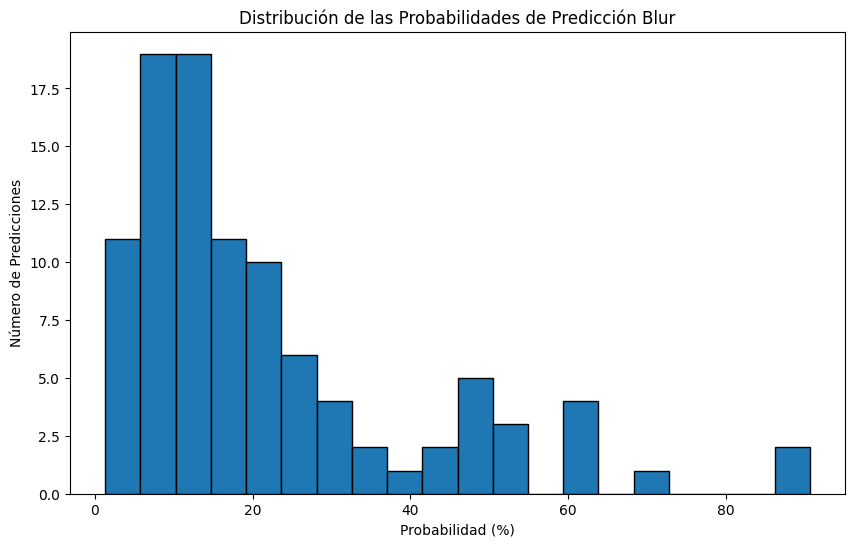

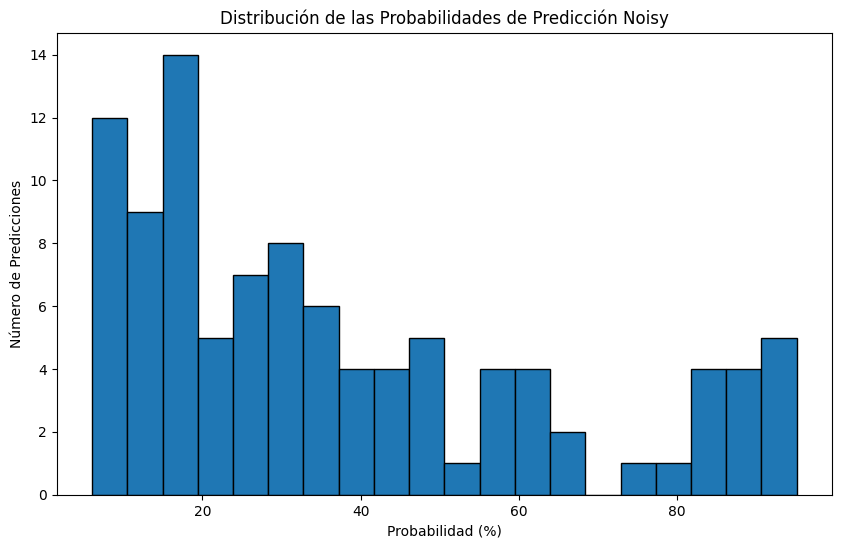

In [40]:
# Graficar el histograma de las probabilidades
plt.figure(figsize=(10, 6))
plt.hist(predictions, bins=20, edgecolor='black')
plt.title("Distribución de las Probabilidades de Predicción Baseline")
plt.xlabel("Probabilidad (%)")
plt.ylabel("Número de Predicciones")
plt.show()
# Graficar el histograma de las probabilidades
plt.figure(figsize=(10, 6))
plt.hist(predictions_blur, bins=20, edgecolor='black')
plt.title("Distribución de las Probabilidades de Predicción Blur")
plt.xlabel("Probabilidad (%)")
plt.ylabel("Número de Predicciones")
plt.show()
# Graficar el histograma de las probabilidades
plt.figure(figsize=(10, 6))
plt.hist(predictions_noise, bins=20, edgecolor='black')
plt.title("Distribución de las Probabilidades de Predicción Noisy")
plt.xlabel("Probabilidad (%)")
plt.ylabel("Número de Predicciones")
plt.show()